In [1]:
import nltk 
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

from google.colab import drive
drive.mount('/drive', force_remount=True)

%cd "/drive/MyDrive/TextMiningProject/"

Mounted at /drive
/drive/MyDrive/TextMiningProject


In [ ]:
!pip install sklearn
!pip install matplotlib
!pip install import_ipynb
!pip install wandb
!pip install pandas
!pip3 install --upgrade pandas

In [7]:
import sys
import os

py_file_location = "/drive/MyDrive/TextMiningProject/text-preprocessing-techniques"
sys.path.append(os.path.abspath(py_file_location))

In [8]:
import pandas as pd
import random
import seaborn as sn
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import GridSearchCV
#import preprocessor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
import import_ipynb
from Utilities import *
from preprocess import tokenize 


In [9]:
genuine_sample, ssb2, ssb3 = generate_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [10]:
train_1, train_2, test_1, test_2 = generate_train_test(genuine_sample, ssb2, ssb3)


/drive/MyDrive/TextMiningProject/Utilities.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssb2_train["Label"] = "bot"
/drive/MyDrive/TextMiningProject/Utilities.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssb3_train["Label"] = "bot"
/drive/MyDrive/TextMiningProject/Utilities.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [11]:
report_values(train_1, train_2, test_1, test_2)

,SSB2 Train,SSB3 Train,SSB2 Test,SSB3 Test
genuine,586732,586732,251457,251457
bot,299755,39749,38521,17036


In [12]:
# Run this cell to downsample
for i in range(7):
  train_1 = downsample_prop(train_1)
  train_2 = downsample_prop(train_2)
  test_1 = downsample_prop(test_1)
  test_2 = downsample_prop(test_2)



In [13]:
train_1=downsample(train_1)
test_1=downsample(test_1)

In [14]:
report_values(train_1, train_2, test_1, test_2)

,SSB2 Train,SSB3 Train,SSB2 Test,SSB3 Test
bot,2322,294,313,150
genuine,2322,4600,313,1948


In [15]:
!pip install -q tf-models-official
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
     |████████████████████████████████| 99 kB 12.0 MB/s 
     |████████████████████████████████| 4.9 MB 49.5 MB/s 
     |████████████████████████████████| 352 kB 75.4 MB/s 
     |████████████████████████████████| 1.2 MB 55.4 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 63.8 MB/s 
     |████████████████████████████████| 90 kB 11.7 MB/s 
     |████████████████████████████████| 213 kB 84.5 MB/s 
     |████████████████████████████████| 596 kB 77.4 MB/s 


In [16]:
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

import numpy as np
import sys
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
%matplotlib inline
import seaborn as sns
sns.set()
import wandb
from wandb.keras import WandbCallback

In [17]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__) 
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [18]:
print('Average word length of tweets in dataset is {0:.0f}.'.format(np.mean(train_1['text'].apply(lambda x: len(x.split())))))
print('Max word length of tweets in dataset is {0:.0f}.'.format(np.max(train_1['text'].apply(lambda x: len(x.split())))))
print('Average character length of tweets in dataset is {0:.0f}.'.format(np.mean(train_1['text'].apply(lambda x: len(x)))))


Average word length of tweets in dataset is 11.
Max word length of tweets in dataset is 73.
Average character length of tweets in dataset is 68.


In [19]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [20]:
input_string = train_1.iloc[0]["text"]
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))


['[UNK]', 'when', 'they', 'have', '[UNK]']
[100, 2043, 2027, 2031, 100]


In [21]:

# to fit the data

train_1["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)
train_2["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)
test_1["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)
test_2["Label"].replace({"genuine": 0, "bot": 1}, inplace=True)



In [22]:
config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':3,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_1),
          'valid_samples': len(test_1),
          'train_split':0.1,
          'valid_split': 0.01
         }

In [23]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier

def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib

    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

    """

    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [24]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """

    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

In [25]:
with tf.device('/gpu:0'):
    train_1 = tf.data.Dataset.from_tensor_slices((train_1['text'].values, train_1['Label'].values))
    test_1 = tf.data.Dataset.from_tensor_slices((test_1['text'].values, test_1['Label'].values))
    # lets look at 3 samples from train set
    for text,label in train_1.take(3):
        print(text)
        print(label)

# Now we will simply apply the transformation to our train and test datasets

with tf.device('/gpu:0'):
  # train
  train_1 = (train_1.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  test_1 = (test_1.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

tf.Tensor(b'Me when they have http://t.co/dSEdpOlaqx', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"If you got a little dick, don't do oral and have ugly feet and I can still see myself being with you then you... http://t.co/MR4vm3dudO", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'If you block a person and they still talking bout shit on your page That hoe stalking you thru other people pages #MiserableTrannyShit', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [26]:
train_1.element_spec


({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [27]:
# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
					    dtype=tf.int32,
                                           name="input_word_ids")

    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
					dtype=tf.int32,
                                   	name= "input_mask" )
 
    input_type_ids = tf.keras.layers.Input(shape= (config[ 'max_seq_length' ] , ) , 
					    dtype=tf.int32,
                                    	    name= "input_type_ids" )
 
 
    pooled_output, sequence_output = bert_layer( [input_word_ids, input_mask, input_type_ids] )
    # for classification we only care about the pooled-output.
    # At this point we can play around with the classification head based on the 
    # downstream tasks and its complexity
 
    drop = tf.keras.layers.Dropout(config[ 'dropout' ] ) (pooled_output)
    output = tf.keras.layers.Dense( 1 , activation= 'sigmoid' , name= 'output' ) (drop)
 
    # inputs coming from the function
    model = tf.keras.Model(
      inputs= {
        'input_word_ids' : input_word_ids,
        'input_mask' : input_mask,
        'input_type_ids' : input_type_ids} , 
      outputs=output)
 
    return model

In [28]:
# Calling the create model function to get the keras based functional model
model = create_model()


In [29]:
# using adam with a lr of 2*(10^-5), loss as binary cross entropy as only 
# 2 classes and similarly binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

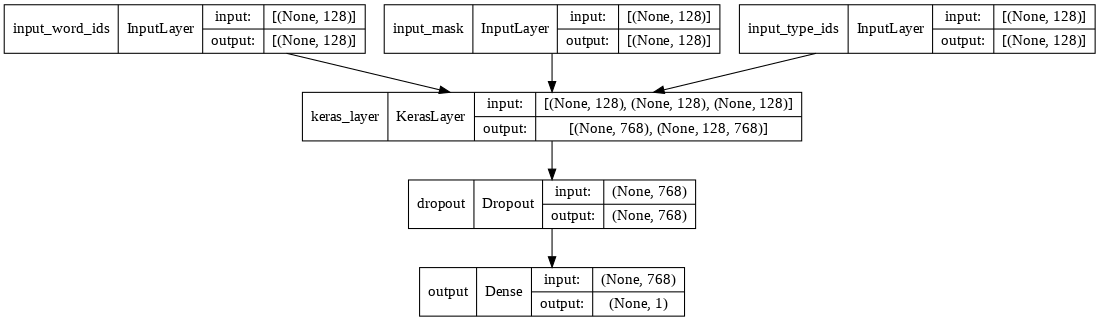

In [30]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76 )


In [31]:
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
config['model_name'] = 'BERT_EN_UNCASED_SSB2'

In [33]:
print('Training configuration: ', config)

# Initialize W&B run
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='train')

Training configuration:  {'label_list': [0, 1], 'max_seq_length': 128, 'train_batch_size': 32, 'learning_rate': 2e-05, 'epochs': 3, 'optimizer': 'adam', 'dropout': 0.5, 'train_samples': 4644, 'valid_samples': 626, 'train_split': 0.1, 'valid_split': 0.01, 'model_name': 'BERT_EN_UNCASED_SSB2'}


In [34]:
from wandb.keras import WandbCallback

# wandb.init(config={"hyper": "parameter"})

# ...  # code to set up your model in Keras

#
# model.fit(X_train, y_train,  validation_data=(X_test, y_test),
#           callbacks=[WandbCallback()])

In [35]:
# Train model
# setting low epochs as It starts to overfit with this limited data, please feel free to change
epochs = config['epochs']
history = model.fit(train_1,
                    validation_data=test_1,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [WandbCallback()])
run.finish()

Epoch 1/3
145/145 [==============================] - 95s 550ms/step - loss: 0.3620 - binary_accuracy: 0.8584 - precision_at_recall: 0.9774 - precision: 0.8744 - recall: 0.8371 - val_loss: 1.2973 - val_binary_accuracy: 0.5872 - val_precision_at_recall: 0.6577 - val_precision: 1.0000 - val_recall: 0.1981
Epoch 2/3
145/145 [==============================] - 89s 606ms/step - loss: 0.3588 - binary_accuracy: 0.8569 - precision_at_recall: 0.9703 - precision: 0.8888 - recall: 0.8160 - val_loss: 1.2628 - val_binary_accuracy: 0.6020 - val_precision_at_recall: 0.7734 - val_precision: 0.9494 - val_recall: 0.2396
Epoch 3/3
145/145 [==============================] - 73s 496ms/step - loss: 0.3732 - binary_accuracy: 0.8621 - precision_at_recall: 0.9451 - precision: 0.8556 - recall: 0.8711 - val_loss: 1.3789 - val_binary_accuracy: 0.6168 - val_precision_at_recall: 0.7913 - val_precision: 0.8704 - val_recall: 0.3003


binary_accuracy,▃▁█
epoch,▁▅█
loss,▃▁█
precision,▅█▁
precision_at_recall,█▆▁
recall,▄▁█
val_binary_accuracy,▁▅█
val_loss,▃▁█
val_precision,█▅▁
val_precision_at_recall,▁▇█
val_recall,▁▄█


In [36]:
# Save model
model.save(f"{config['model_name']}.h5")

# Initialize a new W&B run for saving the model, changing the job_type
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='save')


# Save model as Model Artifact
artifact = wandb.Artifact(name=f"{config['model_name']}", type='model')
artifact.add_file(f"{config['model_name']}.h5")
run.log_artifact(artifact)

# Finish W&B run
run.finish()

wandb: Currently logged in as: alepe026 (use `wandb login --relogin` to force relogin)


In [38]:
True_test_ssb3 = pd.read_csv("/drive/MyDrive/TextMiningProject/Test_set_SSB/No_Tokenized/test_ssb2_true_no_token.csv").drop("Unnamed: 0", axis=1)
True_test_ssb3["Label"] = 1

True_test_genuine = pd.read_csv("/drive/MyDrive/TextMiningProject/Test_set_SSB/No_Tokenized/test_genuine_sample_true_no_token.csv").drop("Unnamed: 0", axis=1)
True_test_genuine["Label"] = 0

True_test_ssb3 = pd.concat([True_test_ssb3, True_test_genuine])
True_test_ssb3= shuffle(True_test_ssb3)



In [39]:
for i in range(3):
  True_test_ssb3 = downsample_prop(True_test_ssb3)

In [40]:
True_test_ssb3 = downsample(True_test_ssb3)

In [41]:
True_test_ssb3.groupby('Label').count()


,text
Label,
0,613
1,613


In [42]:
with tf.device('/gpu:0'):
    True_test_ssb3 = tf.data.Dataset.from_tensor_slices((True_test_ssb3['text'].values, True_test_ssb3['Label'].values))
    # lets look at 3 samples from train set
    for text,label in True_test_ssb3.take(3):
        print(text)
        print(label)

# Now we will simply apply the transformation to our train and test datasets

with tf.device('/gpu:0'):
  
  # True test
  True_test_ssb3 = (True_test_ssb3.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

tf.Tensor(b'Do... or do not. There is no try. - Yoda - The Empire Strikes Back', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"Once you've raced, you never forget it -- and you never get over it. - Richard Childress", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I feel that luck is preparation meeting opportunity. \xc3\xa2\xc2\x80\xc2\x93 Oprah Winfrey', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [43]:
# Initialize a new run for the evaluation-job
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='evaluate')



# Model Evaluation on validation set
evaluation_results = model.evaluate(True_test_ssb3,return_dict=True)

# Log scores using wandb.log()
wandb.log(evaluation_results)

# Finish the run
run.finish()


38/38 [==============================] - 6s 164ms/step - loss: 1.2328 - binary_accuracy: 0.5683 - precision_at_recall: 0.6087 - precision: 0.5841 - recall: 0.4494


binary_accuracy,▁
loss,▁
precision,▁
precision_at_recall,▁
recall,▁
binary_accuracy,0.56826
loss,1.23282
precision,0.58405
precision_at_recall,0.6087
recall,0.44942


In [44]:
evaluation_results

{'binary_accuracy': 0.5682565569877625,
 'loss': 1.2328225374221802,
 'precision': 0.5840517282485962,
 'precision_at_recall': 0.6086956262588501,
 'recall': 0.4494195580482483}

In [45]:
y_prob = model.predict(True_test_ssb3) 
y_classes = y_prob.argmax(axis=-1)


In [46]:
def plot_confusion_matrix_custom(cm):
    
    Labels = ["genuine", "bot"]
    df_cm = pd.DataFrame(cm, index = Labels,
                      columns = Labels)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels.numpy()



In [47]:
y_true = get_labels_from_tfdataset(True_test_ssb3)

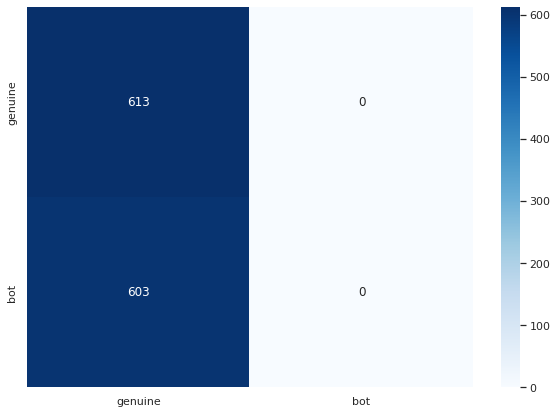

In [48]:

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

cm = confusion_matrix(y_true, y_classes)

plot_confusion_matrix_custom(cm)